<div style="border: 2px solid #FF69B4; background-color: #000000; color: white; padding: 20px; border-radius: 5px;">

# Figure 5

Storylines: Hurricane Helene

---

##### PAST (IFS-FESOM Control, ~1950s climate), PRESENT (IFS-FESOM Historical, current climate), and FUTURE (IFS-FESOM +2K global warming level)

</div>


In [1]:
# Data libraries
import numpy as np
import pandas as pd
import xarray as xr

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

# Seaborn for additional plotting styles
import seaborn as sns

# Cartopy for map plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

# Geospatial operations
from shapely.geometry import Polygon, Point

In [2]:
# Common root directory parts
root1 = "/work/ab0995/a270229/work/data/paper1/story-nudged/data/events/FLD/MODELS/IFS-FESOM"
root2 = "/work/ab0995/a270229/work/data/paper3/data/OBS/ERA5"

# Experiment to subfolder mapping
exp_paths = {
    "wh": f"{root1}/hist/Helene/ENSMEAN",
    "wc": f"{root1}/cont/Helene/ENSMEAN",
    "w2": f"{root1}/2k/Helene/ENSMEAN",
    "we": f"{root2}/Helene",
}

# File patterns per variable
file_patterns = {
    "U_V": {
        "default": "U_V_850_500_IFS-FESOM_hrly_20240924-20240929_HELENE_ext.nc",
        "we": "U_V_850_ERA5_hrly_20240924-20240929_HELENE_ext.nc",
    },
    "TP": {
        "default": "TP_IFS-FESOM_sfc_20240924-20240929_Helene_extended.nc",
        "we": "TP_ERA5_hrly_20240924-20240929_HELENE_ext.nc",
    }
}

# Helper function to load datasets
def load_ds(exp, var):
    folder = exp_paths[exp]
    fname = (
        file_patterns[var].get(exp, file_patterns[var]["default"])
    )
    return xr.open_dataset(f"{folder}/{fname}")

In [3]:
# Load datasets
dtwh = load_ds("wh", "U_V")
dtph = load_ds("wh", "TP")

dtwc = load_ds("wc", "U_V")
dtpc = load_ds("wc", "TP")

dtw2 = load_ds("w2", "U_V")
dtp2 = load_ds("w2", "TP")

dtwe = load_ds("we", "U_V")
dtpe = load_ds("we", "TP")

In [4]:
# Variable mappings for each experiment
components = {
    "h": {"ds_u": dtwh, "ds_p": dtph, "u": "u",       "v": "v",       "p": "tp"},
    "c": {"ds_u": dtwc, "ds_p": dtpc, "u": "u",       "v": "v",       "p": "tp"},
    "2": {"ds_u": dtw2, "ds_p": dtp2, "u": "u",       "v": "v",       "p": "tp"},
    "e": {"ds_u": dtwe, "ds_p": dtpe, "u": "var131",  "v": "var132",  "p": "var228"},
}

# Load all components into variables
for k, v in components.items():
    globals()[f"u{k}"] = v["ds_u"][v["u"]][:, 0, ...]
    globals()[f"v{k}"] = v["ds_u"][v["v"]][:, 0, ...]
    globals()[f"p{k}"] = v["ds_p"][v["p"]][:]


In [5]:
# Create dictionaries of wind components and precipitation
winds = {"wh": (uh, vh), "wc": (uc, vc), "w2": (u2, v2), "we": (ue, ve)}
precip = {"wh": ph, "wc": pc, "w2": p2, "we": pe}

# Compute magnitudes and slice periods required
mag = {}
mag_peak = {}
precip_peak = {}

for key in winds:
    u, v = winds[key]
    mag[key] = np.sqrt(u * u + v * v)
    mag_peak[key] = mag[key][24:96, ...]
    precip_peak[key] = precip[key][24:96, ...] * 1000

<div style="border: 2px solid #00ff40; background-color: #000000; color: white; padding: 20px; border-radius: 5px;">

## Upper part: Maps

Total accum. precipitation during the landfall and wind speed 

---

Time

*2024-09-27T03:00:00*
  
</div>

---
##### Four panels: With ERA5
---

/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bot

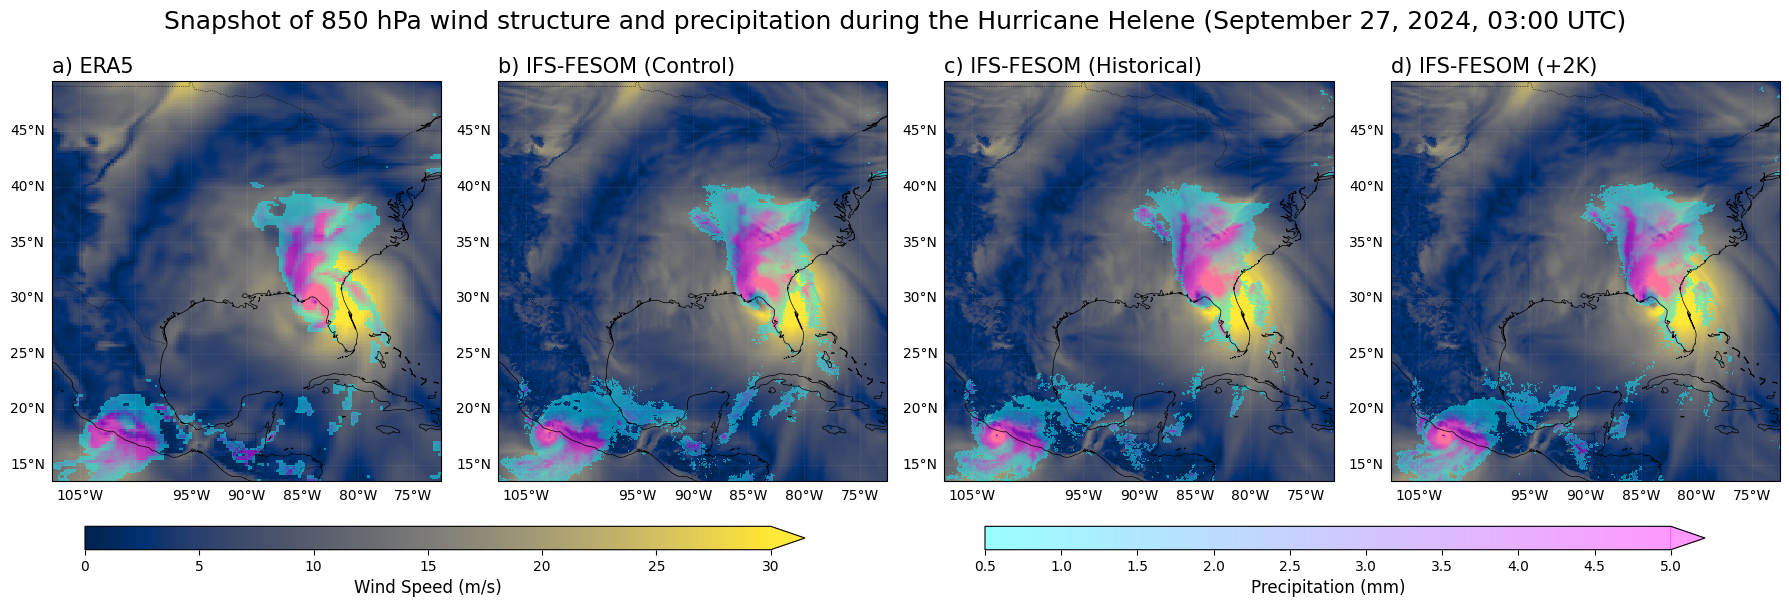

In [6]:
# Choose time index
t_idx = 51

# Extract variables from dictionaries
wind_speed = mag_peak["wh"][t_idx]
precip = precip_peak["wh"][t_idx]

lat = wind_speed.lat
lon = wind_speed.lon

# Define the extent
lat_start, lat_end = 13.5, 49.5
lon_start, lon_end = -107.5, -72.5

# Data for panels
datasets = {
    "a) ERA5": (mag_peak["we"][t_idx], precip_peak["we"][t_idx]),
    "b) IFS-FESOM (Control)": (mag_peak["wc"][t_idx], precip_peak["wc"][t_idx]),
    "c) IFS-FESOM (Historical)": (mag_peak["wh"][t_idx], precip_peak["wh"][t_idx]),
    "d) IFS-FESOM (+2K)": (mag_peak["w2"][t_idx], precip_peak["w2"][t_idx])
}

# Create the figure and subplots
fig, axs = plt.subplots(
    nrows=1, ncols=len(datasets), 
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(18, 18)  # Adjust figure size for horizontal layout
)

# Color maps and normalization
cmap_wind = 'cividis'
cmap_precip = 'cool' #cmapp
wind_norm = Normalize(vmin=0, vmax=30)
precip_norm = Normalize(vmin=0.5, vmax=5.0)

# Loop through the datasets and plot each on its respective axis
for i, (title, (wind, precip)) in enumerate(datasets.items()):
    ax = axs[i]
    ax.set_extent([lon_start, lon_end, lat_start, lat_end], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    
    # Plot wind field
    wind_mesh = ax.pcolormesh(
        lon, lat, wind, 
        cmap=cmap_wind, norm=wind_norm, 
        transform=ccrs.PlateCarree(), alpha=1.0
        
    )
    
    # Plot precipitation, masking zeros to make them transparent
    precip_masked = np.ma.masked_where(precip <= 0.5, precip)
    precip_mesh = ax.pcolormesh(
        lon, lat, precip_masked, 
        cmap=cmap_precip, norm=precip_norm, 
        transform=ccrs.PlateCarree(), alpha=0.5
    )
    
    ax.set_title(title, fontsize=15, loc='left')
    # ax.gridlines(draw_labels=True, linewidth=0.05, color='k', linestyle='--')
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='white', alpha=0.1, linestyle='--', zorder=10)
    gl.ylabels_left = True
    gl.xlabels_bottom = True


# Add colorbars below the plots
cbar_ax1 = fig.add_axes([0.05, 0.41, 0.4, 0.013])  # Adjust position for wind speed
ColorbarBase(cbar_ax1, cmap=cmap_wind, norm=wind_norm, orientation='horizontal', extend='max').set_label('Wind Speed (m/s)', fontsize=12)

cbar_ax2 = fig.add_axes([0.55, 0.41, 0.4, 0.013])  # Adjust position for precipitation
cbar_precip = ColorbarBase(cbar_ax2, cmap=cmap_precip, norm=precip_norm, orientation='horizontal', alpha=0.4, extend='max').set_label('Precipitation (mm)', fontsize=12)

plt.suptitle('Snapshot of 850 hPa wind structure and precipitation during the Hurricane Helene (September 27, 2024, 03:00 UTC)', fontsize=18, x=0.5, y=0.71)

# # Final adjustments and show
plt.tight_layout(rect=[0, 0.14, 1, 1])  # Leave space for the colorbars
# plt.savefig('destine_helene_plot_stories.png', dpi=1000, bbox_inches='tight')

plt.show()


---
##### Three panels: Just Storylines
---

/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bot

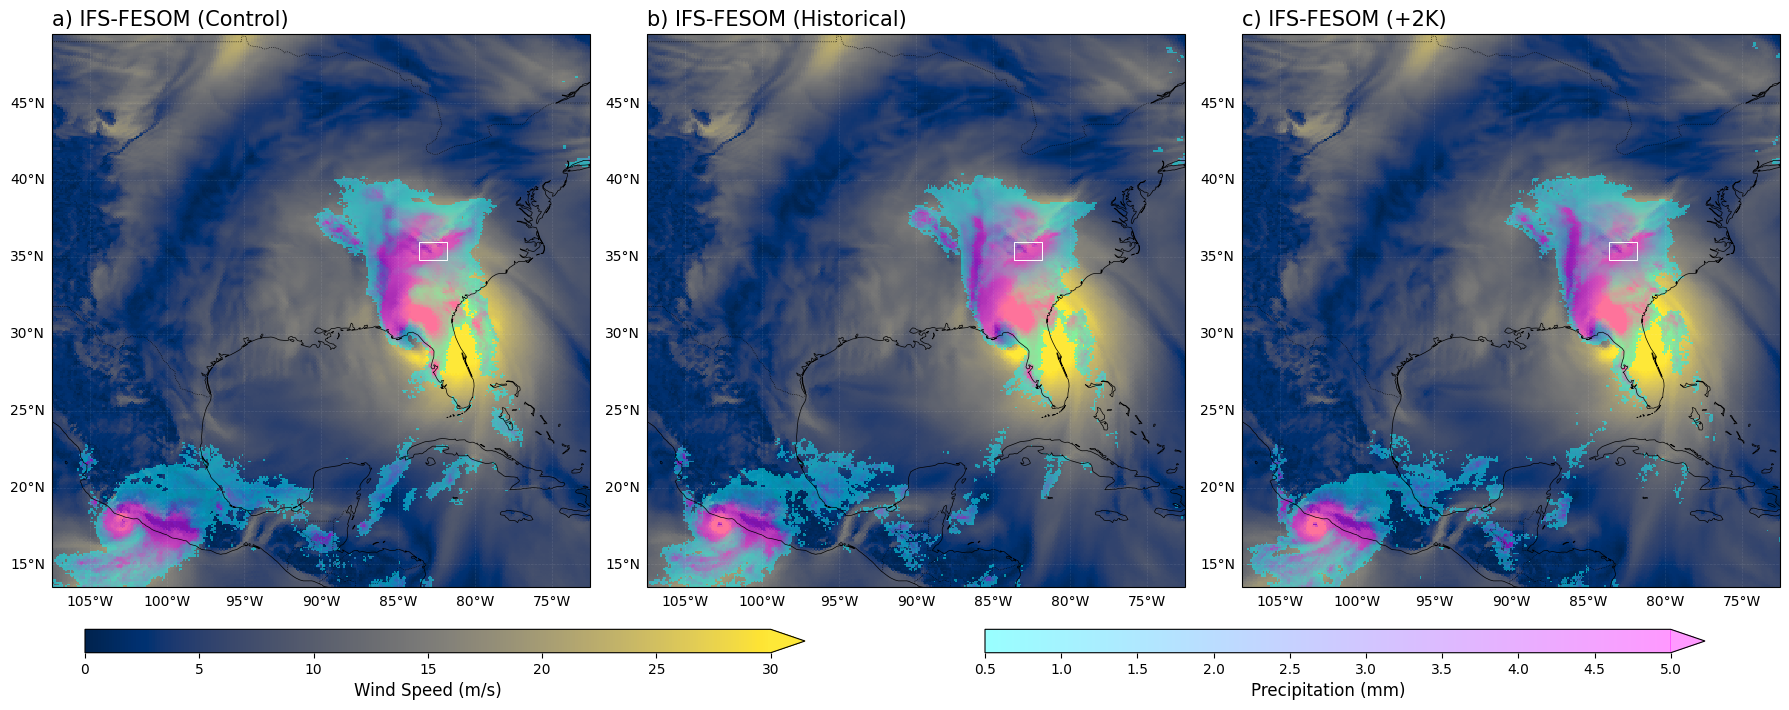

In [7]:
# Choose time index
t_idx = 51

# Extract variables from dictionaries
wind_speed = mag_peak["wh"][t_idx]
precip = precip_peak["wh"][t_idx]

lat = wind_speed.lat
lon = wind_speed.lon

# Define the extent
lat_start, lat_end = 13.5, 49.5
lon_start, lon_end = -107.5, -72.5

# Data for panels
datasets = {
    "a) IFS-FESOM (Control)": (mag_peak["wc"][t_idx], precip_peak["wc"][t_idx]),
    "b) IFS-FESOM (Historical)": (mag_peak["wh"][t_idx], precip_peak["wh"][t_idx]),
    "c) IFS-FESOM (+2K)": (mag_peak["w2"][t_idx], precip_peak["w2"][t_idx])
}

# Create the figure and subplots
fig, axs = plt.subplots(
    nrows=1, ncols=len(datasets), 
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(18, 18)  # Adjust figure size for horizontal layout
)

# Color maps and normalization
cmap_wind = 'cividis'
cmap_precip = 'cool' #cmapp
wind_norm = Normalize(vmin=0, vmax=30)
precip_norm = Normalize(vmin=0.5, vmax=5.0)

# Loop through the datasets and plot each on its respective axis
for i, (title, (wind, precip)) in enumerate(datasets.items()):
    ax = axs[i]
    ax.set_extent([lon_start, lon_end, lat_start, lat_end], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    
    # Plot wind field
    wind_mesh = ax.pcolormesh(
        lon, lat, wind, 
        cmap=cmap_wind, norm=wind_norm, 
        transform=ccrs.PlateCarree(), alpha=1.0
        
    )
    
    # Plot precipitation, masking zeros to make them transparent
    precip_masked = np.ma.masked_where(precip <= 0.5, precip)
    precip_mesh = ax.pcolormesh(
        lon, lat, precip_masked, 
        cmap=cmap_precip, norm=precip_norm, 
        transform=ccrs.PlateCarree(), alpha=0.5
    )
    
    ax.set_title(title, fontsize=15, loc='left')
    # ax.gridlines(draw_labels=True, linewidth=0.05, color='k', linestyle='--')
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='white', alpha=0.1, linestyle='--', zorder=10)
    gl.ylabels_left = True
    gl.xlabels_bottom = True

    polygon_coords = [
            [-83.6, 34.8],  # Bottom-left corner
            [-81.8, 34.8],  # Bottom-right corner
            [-81.8, 36.0],  # Top-right corner
            [-83.6, 36.0],  # Top-left corner
            [-83.6, 34.8]   # Close the polygon
        ]
    ax.add_geometries([Polygon(polygon_coords)], crs=ccrs.PlateCarree(), 
                    facecolor='none', edgecolor='white', linewidth=0.7)


# Add colorbars below the plots
cbar_ax1 = fig.add_axes([0.05, 0.38, 0.4, 0.013])  # Adjust position for wind speed
ColorbarBase(cbar_ax1, cmap=cmap_wind, norm=wind_norm, orientation='horizontal', extend='max').set_label('Wind Speed (m/s)', fontsize=12)

cbar_ax2 = fig.add_axes([0.55, 0.38, 0.4, 0.013])  # Adjust position for precipitation
cbar_precip = ColorbarBase(cbar_ax2, cmap=cmap_precip, norm=precip_norm, orientation='horizontal', alpha=0.4, extend='max').set_label('Precipitation (mm)', fontsize=12)

# plt.suptitle('Snapshot of 850 hPa wind structure and precipitation during the Hurricane Helene (September 27, 2024, 03:00 UTC)', fontsize=18, x=0.5, y=0.71)

# # Final adjustments and show
plt.tight_layout(rect=[0, 0.14, 1, 1])  # Leave space for the colorbars
# plt.savefig('destine_helene_plot_stories_new.png', dpi=1000, bbox_inches='tight', transparent=True)

plt.show()


<div style="border: 2px solid #00ff40; background-color: #000000; color: white; padding: 20px; border-radius: 5px;">

## Lower part: Time series 

Total accum. precipitation and hourly time series

---
- *24/09/2024 - 29/09/2024*
  
</div>

In [8]:
def mask_data_with_polygon(data, lon, lat, polygon_coords, debug=False):
    """
    Masks the input data using a polygonal region.
    
    Parameters:
    - data (xarray.DataArray): The data to be masked.
    - lon (xarray.DataArray): Longitude values.
    - lat (xarray.DataArray): Latitude values.
    - polygon_coords (list of tuples): Polygon coordinates [(lon1, lat1), (lon2, lat2), ...].
    - debug (bool): If True, plots the mask for verification.

    Returns:
    - mask (numpy.ndarray): Boolean mask where True indicates inside the polygon.
    - masked_data (xarray.DataArray): Data with values outside the polygon set to NaN.
    """
    
    # Ensure correct indexing for lon-lat meshgrid
    lon_vals, lat_vals = np.meshgrid(lon.values, lat.values, indexing="xy")

    # Create polygon object
    polygon = Polygon(polygon_coords)

    # Create a boolean mask by checking which points are inside the polygon
    mask = np.array([polygon.contains(Point(lon, lat)) for lon, lat in zip(lon_vals.flatten(), lat_vals.flatten())])
    mask = mask.reshape(lon_vals.shape)

    # Apply the mask to the data
    masked_data = data.where(mask)

    # Debugging: Plot the mask if requested
    if debug:
        plt.figure(figsize=(6, 6))
        plt.imshow(mask, origin="lower", extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap="gray")
        plt.colorbar(label="Mask (1 = Inside, 0 = Outside)")
        plt.scatter(*zip(*polygon_coords), color="red", label="Polygon")
        plt.legend()
        plt.title("Mask Visualization")
        plt.show()

    return mask, masked_data

In [9]:
# Define configurations
# Load data => individal members and mean for analysis

experiments = ['cont', 'hist', '2k']
members = ['ENSMEAN'] + [f'E{i}' for i in range(1, 6)]

# Create data containers
datasets = {}
data = {}

# Load and process data
for member in members:
    datasets[member] = {}
    data[member] = {}
    
    for exp in experiments:
        # Construct file path
        path = (
            f"/work/ab0995/a270229/work/data/paper1/story-nudged/data/events/FLD/"
            f"MODELS/IFS-FESOM/{exp}/Helene/{member}/"
            f"TP_IFS-FESOM_sfc_20240924-20240929_Helene_extended.nc"
        )
        
        # Load dataset
        datasets[member][exp] = xr.open_dataset(path)
        
        # Process precipitation data (convert m to mm)
        data[member][exp] = datasets[member][exp]['tp'] * 1000


In [10]:
# Define regions for the box/polygon to mask
regions = {
    # 'H': [(-83.6, 34.8),(-81.8, 34.8),(-81.8, 36.0),(-83.6, 36.0)]
    'H': [(276.4, 34.8), (278.2, 34.8), (278.2, 36.0), (276.4, 36.0)]
}
     
# Create storage dictionaries
masks = {}
masked_data = {}

for member in members:
    masks[member] = {}
    masked_data[member] = {}
    
    for exp in experiments:
        masks[member][exp] = {}
        masked_data[member][exp] = {}
        
        # Get the DataArray for this member/experiment
        da = data[member][exp]
        
        for region_name, coords in regions.items():
            # Apply masking
            mask, msk_tp = mask_data_with_polygon(da, da.lon, da.lat, coords, debug=False)
            
            # Store results
            masks[member][exp][region_name] = mask
            masked_data[member][exp][region_name] = msk_tp


In [11]:
# Data Processing
def create_region_dataframe(region):
    """Create DataFrame for a specific region."""
    data_dict = {}
    
    for exp, prefix in zip(experiments, ['Cont', 'Hist', 'Tp2K']):
        # Ensemble mean (ENSMEAN)
        data_dict[prefix] = (
            masked_data['ENSMEAN'][exp][region]
            .mean(dim=['lat', 'lon'])
            .to_series()
        )
        
        # Individual members (E1-E5)
        for i in range(1, 6):
            member = f'E{i}'
            data_dict[f'{prefix}{i}'] = (
                masked_data[member][exp][region]
                .mean(dim=['lat', 'lon'])
                .to_series()
            )
    
    return pd.DataFrame(data_dict)

# Create DataFrames for the region
dfh = create_region_dataframe('H')

---
##### Plot timeseries
---

In [12]:
# Function to plot the timeseries as vectors to use in illustrator
def plot_rainfall(dfh, dst, edt, xpms, members=True):
    # Convert to timestamps
    start_time = pd.Timestamp(dst)
    end_time = pd.Timestamp(edt)
    
    # Filter time and cumulative sum
    df_filtered = dfh.loc[start_time:end_time]
    df_accumulated = df_filtered.cumsum()
    
    # Prepare total rainfall for each variable
    total_rainfall_vals = []
    for xpm in xpms:
        if xpm not in df_accumulated.columns:
            # Try create mean from ensemble members like Tp2k1, Tp2k2, ...
            ensemble_cols = [f"{xpm}{i}" for i in range(1,6)]
            if all(col in dfh.columns for col in ensemble_cols):
                df_accumulated[xpm] = df_accumulated[ensemble_cols].mean(axis=1)
            else:
                raise ValueError(f"Variable '{xpm}' or its ensemble members not found in dfh columns.")
        total_rainfall_vals.append(df_accumulated[xpm].iloc[-1])
    
    # Set seaborn style
    sns.set(style="whitegrid")
    sns.set_context("paper")
    
    # Colors (extend or cycle as needed)
    base_colors = ['k', 'r', 'b', 'g', 'm', 'c', 'y']
    colors = base_colors[:len(xpms)]
    
    # Create figure with bar and line plots
    fig, (ax_bar, ax_line) = plt.subplots(
        1, 2, figsize=(10, 6),
        gridspec_kw={'width_ratios': [1, 8], 'wspace': 0.1},
        sharey=True
    )
    
    # Bar Chart (Total accumulated)
    ax_bar.bar(range(len(xpms)), total_rainfall_vals, color=colors, alpha=0.8, width=0.8)
    ax_bar.set_xticks(range(len(xpms)))
    ax_bar.set_xticklabels('', fontsize=12)
    ax_bar.tick_params(axis='y', labelsize=12)
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.yaxis.grid(True, linestyle='--', linewidth=1, alpha=1.0)
    
    # Add values above bars
    for i, val in enumerate(total_rainfall_vals):
        ax_bar.text(i, val + 5, f"{val:.0f}", ha='center', fontsize=14)
    
    # Function to plot ensemble members and mean/std
    def plot_ensemble_members(ax, df, labels, colors, members=True):
        for label, color in zip(labels, colors):
            ensemble_columns = [f"{label}{i}" for i in range(1, 6)]
            if all(col in df.columns for col in ensemble_columns):
                if members:
                    ensemble_data = df[ensemble_columns]
                    mean = ensemble_data.mean(axis=1)
                    std = ensemble_data.std(axis=1)
                    ax.fill_between(df.index, mean - std, mean + std, color=color, alpha=0.3)
            if label in df.columns and not df[label].isnull().all():
                ax.plot(df.index, df[label], color=color, label=label, linewidth=2.0)
    
    # Plot line with cumulative sums for the full dfh
    plot_ensemble_members(ax_line, dfh.cumsum(), xpms, colors, members=members)
    
    # Customize line plot appearance
    ax_line.set_facecolor('white')
    ax_line.spines['top'].set_visible(False)
    ax_line.spines['right'].set_visible(False)
    ax_line.spines['bottom'].set_visible(False)
    ax_line.tick_params(axis='x', labelsize=12)
    
    # Format x-axis dates
    ax_line.xaxis.set_major_locator(mdates.DayLocator())
    ax_line.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    plt.setp(ax_line.xaxis.get_majorticklabels(), rotation=0)
    
    # Set limits and grid
    ax_line.set_xlim([start_time, end_time])
    ax_line.yaxis.grid(True, linestyle='--', linewidth=1, alpha=0.7)
    
    # ax_line.legend()
    plt.show()


In [13]:
dst = '2024-09-24 00:00'
edt = '2024-09-29 00:00'

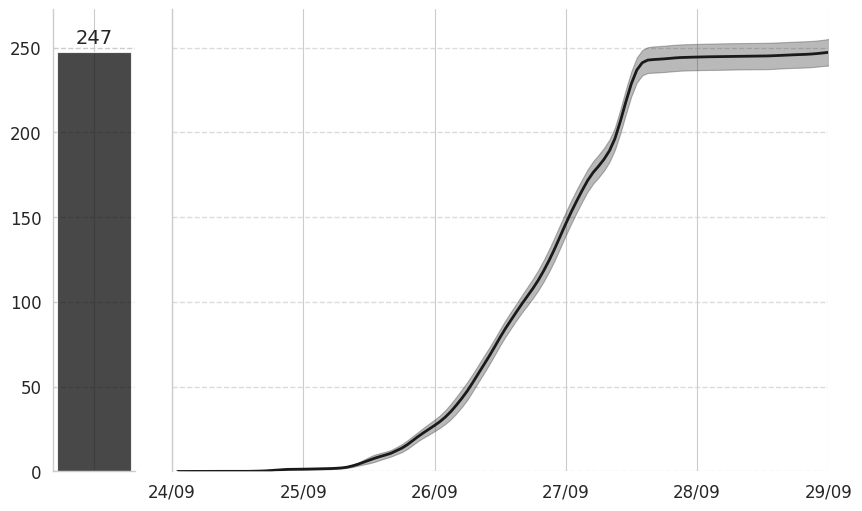

In [14]:
# plot separately for Cont, Hist, Tp2k 
plot_rainfall(dfh, dst, edt, ['Cont'])

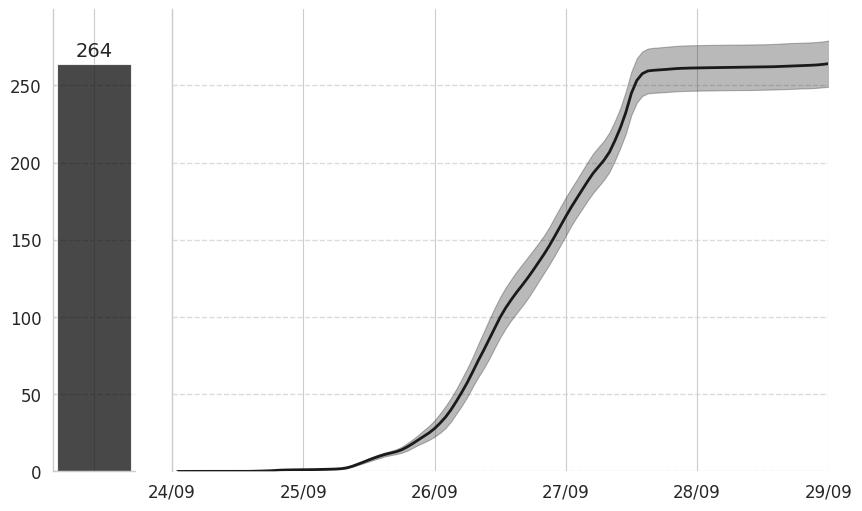

In [15]:
# plot separately for Cont, Hist, Tp2k 
plot_rainfall(dfh, dst, edt, ['Hist'])

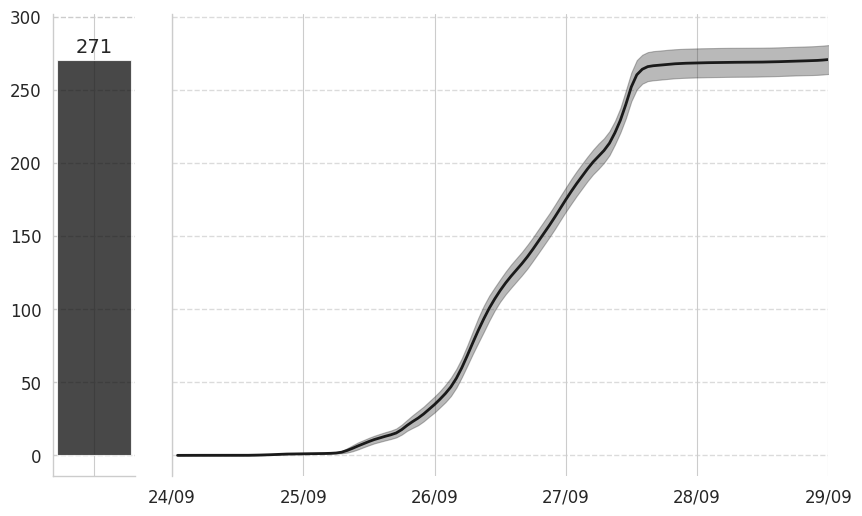

In [16]:
# plot separately for Cont, Hist, Tp2k 
plot_rainfall(dfh, dst, edt, ['Tp2K'])